# Customer outflow

Customers began to leave the bank. Every month. A little, but noticeable. Bank marketers have calculated that it is cheaper to retain current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. You are presented with historical data on the behavior of customers and the termination of contracts with the bank.

It is necessary to build a model with an extremely large value of the F1-measure. We need to bring the metric up to 0.59. Check the F1 measure on a test sample.

Additionally, it is necessary to measure AUC-ROC, compare its value with the F1-measure.

### The purpose of the study

- It is necessary to build a model with an extremely large value of F1-measure, which will predict whether the client will leave. - Bring the metric to 0.59.
- Check the F1 measure on a test sample.
- Measure AUC-ROC, compare its value with F1-measure.

### Data Description

<b>Features</b>
- RowNumber — index of the row in the data
- CustomerID — unique identifier of the customer
- Surname — surname
- CreditScore — credit rating
- Geography — country of residence
- Gender — gender
- Age — age
- Tenure — how many years has a person been a customer of the bank
- Balance — account balance
- NumOfProducts — the number of bank products used by the customer
- HasCrCard — availability of a credit card
- IsActiveMember — client activity
- EstimatedSalary — estimated salary

<b>Target </b>
- Exited — the fact of the client's departure

<b>Plan of research</b>

It is optimal to conduct a study according to the following plan:

- Data preparation.
- Study of the balance of classes, training model without taking into account the imbalance.
- Improve the quality of the model, taking into account the imbalance of classes. Train different models and find the best one.
- Conduct final testing.

## Data preparation.

To begin with, it is better to import all the necessary libraries for work:

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None 

#module for sample separation
from sklearn.model_selection import train_test_split

##library for standard scaling
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

##Decision Tree
from sklearn.tree import DecisionTreeClassifier

#Random Forest 
from sklearn.ensemble import RandomForestClassifier

#Logistic regression
from sklearn.linear_model import LogisticRegression

#Accuracy
from sklearn.metrics import accuracy_score

#error matrix
from sklearn.metrics import confusion_matrix

#recall
from sklearn.metrics import recall_score

#precision
from sklearn.metrics import precision_score

#F-1 score
from sklearn.metrics import f1_score

#AUC-ROC
from sklearn.metrics import roc_auc_score

#ROC-curve
from sklearn.metrics import roc_curve

#module for sequential mixing of arrays
from sklearn.utils import shuffle

#method for iterating parameters
from itertools import product

Let's download the data and study them:

In [14]:
try:
    df = pd.read_csv('/Users/vladislav/Documents/datasets//Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [15]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [16]:
df.columns = map(str.lower, df.columns)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Fill in missing values:

In [18]:
df['tenure'] = df['tenure'].fillna(-1)

In [19]:
def make_pie_plot(data, name):
    counts = data.value_counts()
    counts.plot.pie(legend=True, labeldistance=1.2, autopct='%1.2f%%', figsize=(12,6), title=name)
    plt.show()

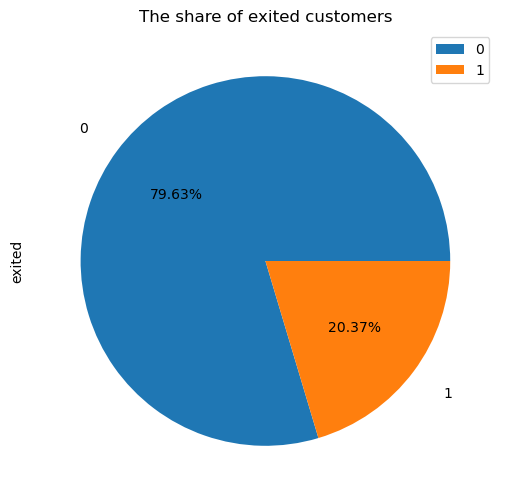

In [20]:
make_pie_plot(df['exited'], 'The share of exited customers')
# 1 = Да, 0 = Нет

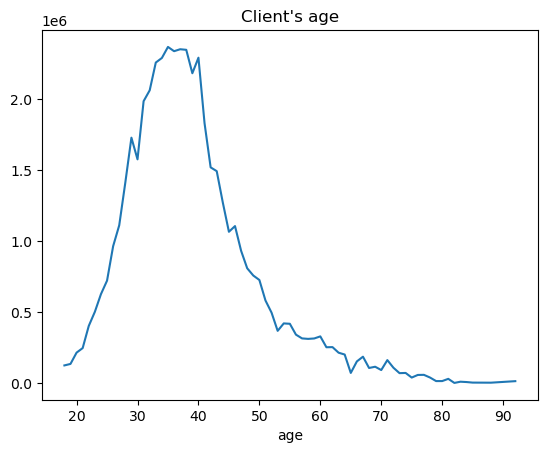

In [21]:
df.pivot_table(index='age', values='rownumber', aggfunc='sum').sort_values('age', ascending=False).plot(legend=False, title="Client's age")
plt.show()

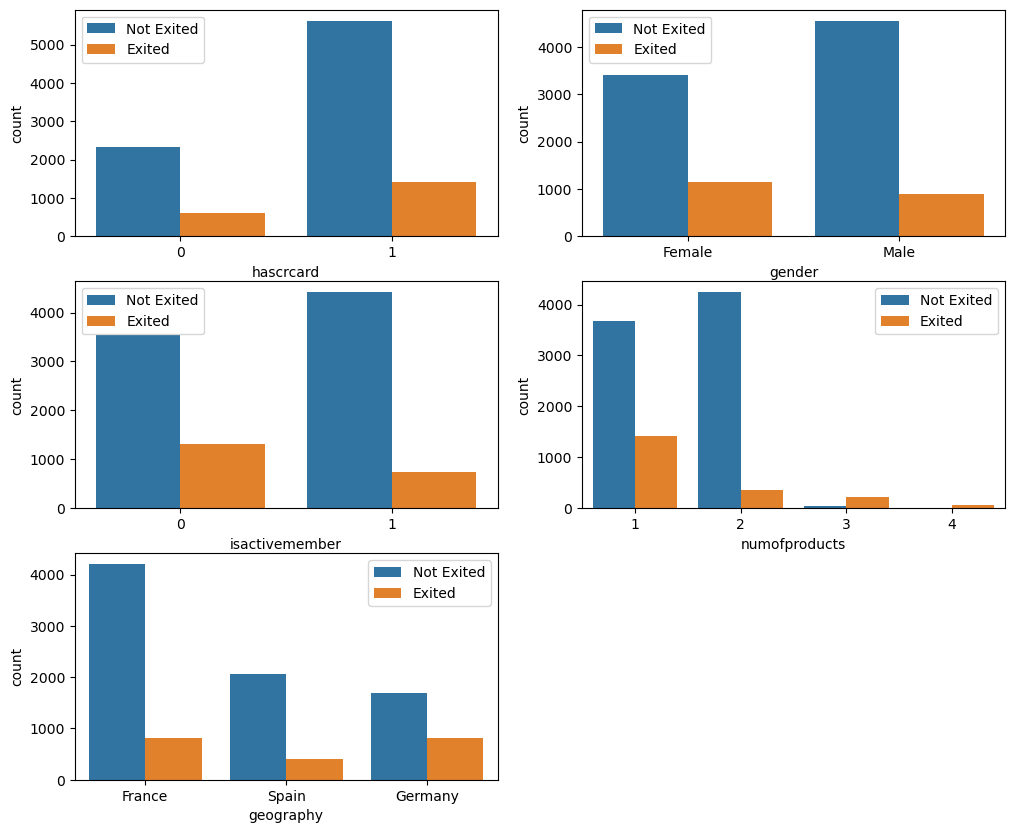

In [22]:
plt.figure(figsize=(12,10))
columns = ['hascrcard', 'gender', 'isactivemember', 'numofproducts', 'geography']
for i in range(5):
    plt.subplot(3, 2, i+1)
    sns.countplot(x=columns[i], hue='exited', data=df)
    plt.xticks(rotation=0)
    plt.legend(["Not Exited", "Exited"])
plt.show()

The dataset contains 10000 rows, no obvious missing values were detected.
Required changes:

RowNumber — the column duplicates the information of the standard dataframe and has no value for training the model. Therefore, the column can be deleted

CustomerID is the user ID (for this column, the value must be checked for duplicates) and if there are none, this column can also be deleted.

Surname — is user—identifying information, but has no value for the quality of the future model - the column can be deleted.

CreditScore — this column should be saved.

Geography — only 3 unique values France', 'Spain', 'Germany' — perform OHE / ordinal encoding conversion

Gender — convert value — OHE / ordinal encoding.

Let's remove unnecessary columns. Denote target and features using the function

In [23]:
df = df.drop(['rownumber','customerid','surname'], axis=1)
rnd_state = 12345

In [24]:
def make_target_features(data, target_col='exited'):    
    target = data[target_col]
    features = data.drop(target_col, axis=1)
    return target, features

Let's divide the initial data set into three parts: training, validation and test sets. The sizes of the test and validation sets will be 60% \ 20% \ 20%

In [25]:
def split_data(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.6, random_state=rnd_state)

    features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=rnd_state)
    # Scaling quantitative features
    scaler = StandardScaler()
    numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

The function returns the trained model

In [26]:
def train_and_predict(data, model, log_prefix='', samplefunc=None, test=False):
    target, features = make_target_features(data)
    features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)

    if samplefunc:
        features_train, target_train = samplefunc(features_train, target_train)
    
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print(f'{log_prefix}F1 of valid: {f1_score(target_valid, predicted_valid)}')
    
    if test:
        predictions_test = model.predict(features_test)
        print(f'{log_prefix}F1 of test: {f1_score(target_test, predicted_test)}')
        
    
    return model

Next we transform categorical features into numerical ones

In [27]:
data_ohe = pd.get_dummies(df, drop_first=True)

## Let's study balance of classes, learning model without taking into account the imbalance.

Let's check how often the class "1" or "0" occurs in the target attribute of our source dataset:

In [28]:
frequency_of_0_1 = df['exited'].value_counts(normalize=True)
frequency_of_0_1

0    0.7963
1    0.2037
Name: exited, dtype: float64

The ratio is not balanced: negative ~ 80% and positive ~ 20%. At this stage, we will explore models without taking into account the imbalance of classes, obviously expecting bad results.

Some of the data is categorical. To train a logistic regression model, we need to transform categorical features by direct coding, and to train a model of a decision tree or a random forest, we need to perform ordinal coding. Let's apply the technique of ordinal coding for categorical features.

In [29]:
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [30]:
encoder = OrdinalEncoder()
data_ordinal = df
data_ordinal[['geography','gender']] = encoder.fit_transform(data_ordinal[['geography','gender']])
data_ordinal.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,0.0,0.0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2.0,0.0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0.0,0.0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,0.0,0.0,39,1.0,0.00,2,0,0,93826.63,0
4,850,2.0,0.0,43,2.0,125510.82,1,1,1,79084.10,0


### Logistic regression

In [31]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model)

F1 of valid: 0.32941176470588235


LogisticRegression(random_state=12345, solver='liblinear')

Poor F1 performance with data imbalance

### Decision Tree Classifier

In [32]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1 of valid: 0.5095057034220531
max_depth 4:	F1 of valid: 0.494773519163763
max_depth 6:	F1 of valid: 0.5178571428571429
max_depth 8:	F1 of valid: 0.5317220543806646
max_depth 10:	F1 of valid: 0.5132223310479921
max_depth 12:	F1 of valid: 0.4790419161676647
max_depth 14:	F1 of valid: 0.49228269699431354
max_depth 16:	F1 of valid: 0.4873417721518988
max_depth 18:	F1 of valid: 0.4792993630573248
max_depth 20:	F1 of valid: 0.4854673998428908


The best indicator at a depth of 8: max_depth 4: F1 of valid: 0.5317220543806646

### Random Forest Classifier

In [33]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=4, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1 of valid: 0.5017341040462427
n_estimators = 20:	F1 of valid: 0.4520048602673147
n_estimators = 30:	F1 of valid: 0.45232273838630804
n_estimators = 40:	F1 of valid: 0.4611650485436894
n_estimators = 50:	F1 of valid: 0.4452644526445264
n_estimators = 60:	F1 of valid: 0.44499381953028433
n_estimators = 70:	F1 of valid: 0.44389642416769426
n_estimators = 80:	F1 of valid: 0.45797807551766134
n_estimators = 90:	F1 of valid: 0.44963144963144963
n_estimators = 100:	F1 of valid: 0.44389642416769426
n_estimators = 110:	F1 of valid: 0.4367245657568239
n_estimators = 120:	F1 of valid: 0.44554455445544555
n_estimators = 130:	F1 of valid: 0.42999999999999994
n_estimators = 140:	F1 of valid: 0.44139650872817954
n_estimators = 150:	F1 of valid: 0.44801980198019803
n_estimators = 160:	F1 of valid: 0.45297029702970304
n_estimators = 170:	F1 of valid: 0.4507389162561577
n_estimators = 180:	F1 of valid: 0.44857496902106564
n_estimators = 190:	F1 of valid: 0.45185185185185184
n_estima

Best result with 10 trees: n_estimators = 10: F1 of valid: 0.5017341040462427

## Improving the quality of the model, taking into account the imbalance of classes

Let's give objects of rare class 1 more weight using the hyperparameter class_weight='balanced'

### Weighing classes

#### Logistic regression

In [34]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model)

F1 of valid: 0.48023255813953497


LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')

The result is slightly better than with unbalanced data

#### Decision Tree Classifier

In [35]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(class_weight='balanced', max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1 of valid: 0.48306010928961746
max_depth 4:	F1 of valid: 0.532133676092545
max_depth 6:	F1 of valid: 0.5494505494505495
max_depth 8:	F1 of valid: 0.5035885167464115
max_depth 10:	F1 of valid: 0.48835745752045306
max_depth 12:	F1 of valid: 0.493361285814116
max_depth 14:	F1 of valid: 0.48976497346474607
max_depth 16:	F1 of valid: 0.47123719464145
max_depth 18:	F1 of valid: 0.4789180588703262
max_depth 20:	F1 of valid: 0.4654895666131621


Best result with a depth of 6: max_depth 6: F1 of valid: 0.5494505494505495

#### Random Forest Classifier

In [36]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(class_weight='balanced', n_estimators=estim, max_depth=6, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1 of valid: 0.5808339429407461
n_estimators = 20:	F1 of valid: 0.590782122905028
n_estimators = 30:	F1 of valid: 0.5936842105263158
n_estimators = 40:	F1 of valid: 0.6023926812104152
n_estimators = 50:	F1 of valid: 0.5956552207428171
n_estimators = 60:	F1 of valid: 0.5977496483825597
n_estimators = 70:	F1 of valid: 0.5960729312762973
n_estimators = 80:	F1 of valid: 0.5955369595536959
n_estimators = 90:	F1 of valid: 0.5959805959805959
n_estimators = 100:	F1 of valid: 0.5944827586206897
n_estimators = 110:	F1 of valid: 0.5947441217150761
n_estimators = 120:	F1 of valid: 0.5925414364640884
n_estimators = 130:	F1 of valid: 0.5927977839335179
n_estimators = 140:	F1 of valid: 0.5956854558107167
n_estimators = 150:	F1 of valid: 0.5955369595536959
n_estimators = 160:	F1 of valid: 0.5933147632311977
n_estimators = 170:	F1 of valid: 0.5941422594142259
n_estimators = 180:	F1 of valid: 0.5952380952380952
n_estimators = 190:	F1 of valid: 0.592280701754386
n_estimators = 200:	F1 

Лучший результат с количеством деревьев 170: n_estimators = 170: Допустимое значение F1: 0,5962473940236276

### Increasing the sample

Let's increase the objects of a rare class and retrain the models.

In [37]:
def upsample(features, target, repeat=4):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rnd_state)
    
    return features_upsampled, target_upsampled

#### Logistic regression

In [38]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model, samplefunc=upsample)

F1 of valid: 0.4772599663110612


LogisticRegression(random_state=12345, solver='liblinear')

#### Decision Tree Classifier

In [39]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=upsample, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1 of valid: 0.48306010928961746
max_depth 4:	F1 of valid: 0.48651399491094155
max_depth 6:	F1 of valid: 0.5473145780051151
max_depth 8:	F1 of valid: 0.5002985074626867
max_depth 10:	F1 of valid: 0.48557089084065247
max_depth 12:	F1 of valid: 0.4986449864498645
max_depth 14:	F1 of valid: 0.4766146993318486
max_depth 16:	F1 of valid: 0.4798136645962732
max_depth 18:	F1 of valid: 0.49005568814638023
max_depth 20:	F1 of valid: 0.4768856447688565


Best result with depth 6: max_depth 6: F1 of valid: 0.5473145780051151

#### Random Forest Classifier

In [40]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=6, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=upsample, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1 of valid: 0.54351909830933
n_estimators = 20:	F1 of valid: 0.5656050955414013
n_estimators = 30:	F1 of valid: 0.5652173913043478
n_estimators = 40:	F1 of valid: 0.5682989690721649
n_estimators = 50:	F1 of valid: 0.5692208628461043
n_estimators = 60:	F1 of valid: 0.5681233933161953
n_estimators = 70:	F1 of valid: 0.5694267515923567
n_estimators = 80:	F1 of valid: 0.5681674064679773
n_estimators = 90:	F1 of valid: 0.5745222929936306
n_estimators = 100:	F1 of valid: 0.5736040609137056
n_estimators = 110:	F1 of valid: 0.5743329097839899
n_estimators = 120:	F1 of valid: 0.5721551176096631
n_estimators = 130:	F1 of valid: 0.5730622617534942
n_estimators = 140:	F1 of valid: 0.5734355044699873
n_estimators = 150:	F1 of valid: 0.5738019169329074
n_estimators = 160:	F1 of valid: 0.5738019169329074
n_estimators = 170:	F1 of valid: 0.5749039692701665
n_estimators = 180:	F1 of valid: 0.5732565579014716
n_estimators = 190:	F1 of valid: 0.5743589743589744
n_estimators = 200:	F1 

The best result with the number of trees is 90: n_estimators = 90: F1 of valid: 0.5745222929936306

The value of the F1-measure for each of the considered models is less than in the case of class balancing

Let's try sample reduction

### Sample reduction

In [41]:
def downsample(features, target, fraction = 0.2):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=rnd_state)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=rnd_state)] + [target_ones]
    )
    
    return features_downsampled, target_downsampled

#### Logistic regression

In [42]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model, samplefunc=downsample)

F1 of valid: 0.46421471172962225


LogisticRegression(random_state=12345, solver='liblinear')

#### DecisionTreeClassifier

In [43]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=downsample, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1 of valid: 0.5234270414993307
max_depth 4:	F1 of valid: 0.4926160337552743
max_depth 6:	F1 of valid: 0.5134670487106018
max_depth 8:	F1 of valid: 0.48527048741296197
max_depth 10:	F1 of valid: 0.45963401506996776
max_depth 12:	F1 of valid: 0.46336206896551724
max_depth 14:	F1 of valid: 0.46203904555314534
max_depth 16:	F1 of valid: 0.4548892490545651
max_depth 18:	F1 of valid: 0.4548892490545651
max_depth 20:	F1 of valid: 0.4548892490545651


Best result at depth 2: max_depth 2: F1 of valid: 0.5234270414993307

#### RandomForestClassifier

In [44]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=2, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=downsample, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1 of valid: 0.4738292011019284
n_estimators = 20:	F1 of valid: 0.4797421731123388
n_estimators = 30:	F1 of valid: 0.4724199288256227
n_estimators = 40:	F1 of valid: 0.4704821991888238
n_estimators = 50:	F1 of valid: 0.46488888888888885
n_estimators = 60:	F1 of valid: 0.456369982547993
n_estimators = 70:	F1 of valid: 0.4609306409130816
n_estimators = 80:	F1 of valid: 0.46457399103139013
n_estimators = 90:	F1 of valid: 0.46275197195442597
n_estimators = 100:	F1 of valid: 0.4556521739130435
n_estimators = 110:	F1 of valid: 0.45529157667386605
n_estimators = 120:	F1 of valid: 0.46167323696890056
n_estimators = 130:	F1 of valid: 0.457117979973879
n_estimators = 140:	F1 of valid: 0.4556852572416775
n_estimators = 150:	F1 of valid: 0.4619445666520018
n_estimators = 160:	F1 of valid: 0.46490835940992403
n_estimators = 170:	F1 of valid: 0.46256092157731504
n_estimators = 180:	F1 of valid: 0.4601769911504425
n_estimators = 190:	F1 of valid: 0.4663960306720793
n_estimators = 2

Best result with 20 trees: n_estimators = 60: F1 of valid: 0.4797421731123388

The value of the F1-measure for each of the considered models is less than in the case of class balancing. In the case of the Decision Tree Classifier, the difference is small.

### Conclusion based on the results of the study

There was a significant imbalance in the initial data (80% of the responses of the target trait were negative and only 20% positive). All models of non-initial data were characterized by low quality of the weighted value (F1).

We eliminated the imbalance of classes in the training sample by upsampling — increased the number of positive class values by 4 times. This is how we achieved the balance of classes in the training sample.

On the new data, all models showed a higher result than on the unbalanced sample.

It was decided to continue improving the model based on the Random Forest Classifier algorithm

The model was improved by a cycle of selecting hyperparameters that showed the highest value of the F1 measure and did not lead the model to retraining.

The final parameters of the selected model are RandomForestClassifier(n_estimators = 170, random_state=12345).
Model results:
F1-measure 0.5962473940236276

## Testing the model

The best result was shown by the Random Forest Classifier model with a depth of 6 and a number of trees of 170

In [45]:
target, features = make_target_features(data_ordinal)
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)

model = RandomForestClassifier(class_weight='balanced', n_estimators=170, max_depth=6, random_state=rnd_state)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print('valid:', f1_score(target_valid, predicted_valid))

predicted_test = model.predict(features_test)
print('test:', f1_score(target_test, predicted_test))

valid: 0.5941422594142259
test: 0.5965156794425087


Let's calculate the AUC-ROC for our model and see how much better it is than the random model

In [46]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc_score(target_valid, probabilities_one_valid)

0.8525085465614406

In [47]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

roc_auc_score(target_test, probabilities_one_test)

0.8529759023951655

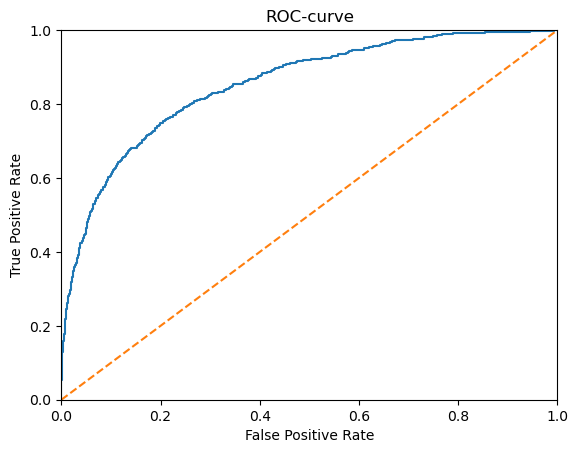

In [48]:
final_model_probabilities_one = model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, final_model_probabilities_one) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

The final model has reached the specified metric (F1 > 0.59) and shows adequate results, so it is highly likely to predict the client's exit from the bank.

## General conclusion

Considering the data with the adjustment of the imbalance, as well as with the transfromation of categorical data and the standardization of data by three models, we can conclude that the best model turned out to be a Random Forest. With the best value max_depth=6,n_estimators=170, we have F1 measure =0.596 on a test (valid) sample. The Logistic regression model proved to be the worst